# Simple GAN 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import torchvision
import torchvision.transforms as transforms

In [2]:
# Import some data

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
    
batch_size = 128
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

C:\Users\mhart\anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


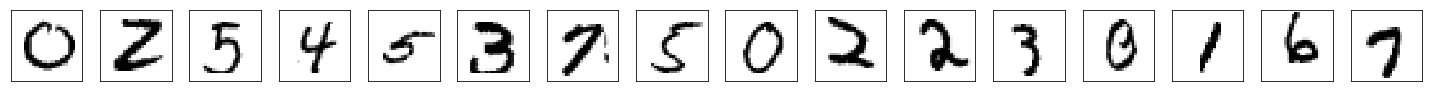

In [3]:
fig = plt.figure(figsize=(20,5))
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(1, 16, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()  

In [4]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
cols = 3
rows = 3
z_dim = 100
Z_examples = torch.rand((cols*rows,z_dim)) # latent vectors used to generate samples

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Linear(z_dim,128),
            #nn.LeakyReLU(), # Leaky ReLU
            #nn.Linear(128,img_rows*img_cols),
            #nn.Tanh(), # Output layer with tanh activation
            nn.Linear(z_dim,7*7), # create 7x7x2 images
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7,7*7*2), # create 7x7x2 images
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7*2,7*7*4), # increase image dimension 
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7*4,7*7*8), # increase image dimension 
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7*8,7*7*16), # increase image dimension 
            nn.Tanh()
        )
    def forward(self,x):
        output = self.model(x)
        output = output.view(x.shape[0],channels,img_rows,img_cols)
        return output
    def train(self,N_samples,z_dim,discriminator,loss_function,optimizer):
        self.zero_grad()
        label = torch.ones((N_samples,1)) # the generator wants the discriminator to label the generated samples as real
        Z = torch.rand((N_samples,z_dim))
        generated_samples = self.forward(Z)
        outputs = discriminator(generated_samples) #pass the fake batch in the just-trained discriminator
        loss = loss_function(outputs,label)
        loss.backward()
        optimizer.step()
        return loss
    def init_weights(self):
        if isinstance(self, nn.Linear):
            torch.nn.init.normal_(self.weight)
            m.bias.data.fill_(0.01)
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Flatten(),
            #nn.Linear(img_rows*img_cols*channels,128),
            #nn.LeakyReLU(),
            #nn.Linear(128,1),
            #nn.Sigmoid(),
            nn.Flatten(),
            nn.Linear(img_rows*img_cols*channels,7*7*8), # decimate image dimension
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7*8,7*7*4), # decimate image dimension
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7*4,7*7*2), # decimate image dimension
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7*2,7*7), # decimate image dimension
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7,1),
            #nn.Tanh()
        )
    def forward(self,x):
        #inp = x.view(x.shape[0],img_rows*img_cols*channels)
        output = self.model(x)
        return output
    def train(self,samples,labels,loss_function,optimizer):
        self.zero_grad()
        outputs = self.forward(samples)
        loss = loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        return loss
    def init_weights(self):
        if isinstance(self, nn.Linear):
            torch.nn.init.normal_(self.weight)
            m.bias.data.fill_(0.01)

In [6]:
def get_samples_and_labels(real_samples,N_samples,z_dim):
    # Define the labels for the real samples
    label_real = torch.ones((N_samples,1))
    # Then, generate the fake data
    Z = torch.rand((N_samples,z_dim))
    fake_samples = generator(Z) #.detach()
    label_fake = torch.zeros((N_samples,1))
    # Concatenate the real and fake data into a large training set 
    samples = torch.cat((real_samples,fake_samples))
    labels = torch.cat((label_real,label_fake))
    return samples,labels

In [7]:
generator = Generator()
discriminator = Discriminator()

In [8]:
# hyper-parameters
lr = 0.0002 #1e-4
num_epochs = 50 #200
interval_gen_training = 3 # Train the generator only every ... epoch
sample_interval = 5
init_nets = True

In [9]:
loss_function = nn.MSELoss() #nn.BCEWithLogitsLoss() #nn.HingeEmbeddingLoss()  # nn.BCELoss() # binary cross entropy
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr = lr)

In [17]:
loss_d = torch.zeros(num_epochs)
loss_g = torch.zeros(num_epochs)
if len(loss_d)!=0:
    loss_d = torch.cat((loss_d,torch.zeros(num_epochs)))
    loss_g = torch.cat((loss_g,torch.zeros(num_epochs)))
    
#cur_epoch = 0
print(cur_epoch)
init_nets = False

98


In [18]:
if init_nets == True:
    generator.init_weights()
    discriminator.init_weights()

for epoch in range(cur_epoch,cur_epoch+num_epochs):
    print('Epoch %d' %epoch)
    for n, (real_samples, _) in enumerate(train_loader):
        N_samples = real_samples.shape[0]
        # First, train the discriminator 
        samples, labels = get_samples_and_labels(real_samples,N_samples,z_dim)
        # Train the discriminator on this set
        loss_discriminator = discriminator.train(samples,labels,loss_function,optimizer_discriminator)
        if epoch % interval_gen_training==0:
            # And now, train the generator
            loss_generator = generator.train(N_samples,z_dim,discriminator,loss_function,optimizer_generator)
    # Show loss and performance every sample_interval epoch
    #if epoch % sample_interval == 0: #and n == batch_size - 1:
    loss_d[epoch] = loss_discriminator
    loss_g[epoch] = loss_generator
    print('Discriminator loss',loss_discriminator.detach())
    print('Generator loss',loss_generator.detach() )
    if epoch%sample_interval ==0:
        # Show some generated samples computed at this epoch
        images_to_show = generator(Z_examples)
        images_to_show = 0.5*images_to_show.detach().squeeze()+0.5 # just a small rescaling
        plt.figure(figsize=(10,8))
        plt.title('Evolution of the generated samples')
        for cnt in range(1,rows*cols+1):
            plt.subplot(rows,cols,cnt)
            plt.imshow(images_to_show[cnt-1,:,:],cmap = 'gray')
            plt.axis('off')
        plt.show()

cur_epoch = epoch

Epoch 98
Discriminator loss tensor(0.0104)
Generator loss tensor(0.6588)
Epoch 99
Discriminator loss tensor(0.1866)
Generator loss tensor(0.4829)
Epoch 100


<class 'IndexError'>: index 100 is out of bounds for dimension 0 with size 100

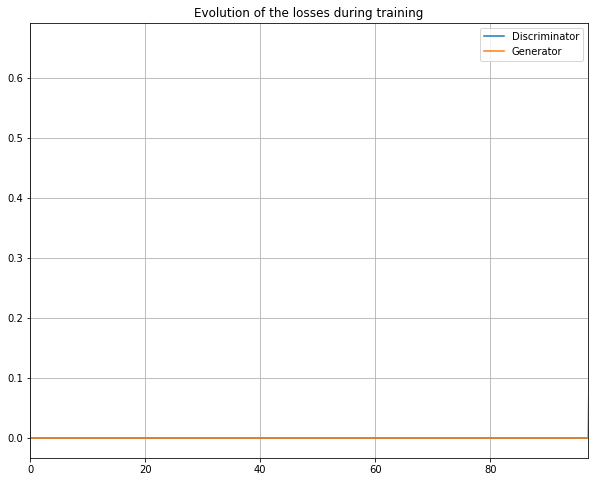

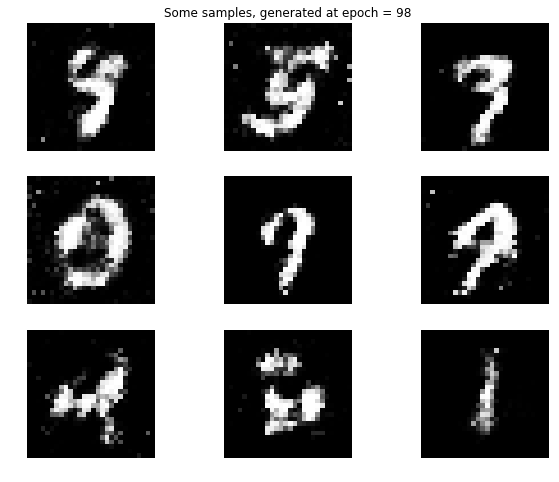

In [19]:
plt.figure(1,figsize=(10,8))
plt.plot(loss_d.detach())
plt.plot(loss_g.detach())
plt.grid()
plt.legend(['Discriminator','Generator'])
plt.title('Evolution of the losses during training')
plt.xlim([0,cur_epoch-1])
plt.show()

images_to_show = generator(Z_examples)
images_to_show = 0.5*images_to_show.detach().squeeze()+0.5 # just a small rescaling
plt.figure(figsize=(10,8))
cnt = 0
for cnt in range(1,rows*cols+1):
    plt.subplot(rows,cols,cnt)
    plt.imshow(images_to_show[cnt-1,:,:],cmap = 'gray')
    plt.axis('off')
    if cnt ==2:
        plt.title('Some samples, generated at epoch = %d' %cur_epoch)
    cnt+=1
plt.show()
cur_epoch = epoch